# DGMR: 利用深度生成模型实现短临降水预报

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindearth/zh_cn/nowcasting/mindspore_DgmrNet.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindearth/zh_cn/nowcasting/mindspore_DgmrNet.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.5.0/docs/mindearth/docs/source_zh_cn/nowcasting/DgmrNet.ipynb)


## 概述

DgmrNet（雷达网络深度生成模型）是由DeepMind的研究人员开发的雷达降水概率临近预报的深度生成模型。它可以对面积达1,536公里×1,280公里的区域进行现实且时空一致的预测，并且提前时间为5至90分钟。该方法由50多名专业气象学家进行系统评估，结果表明，与两种竞争方法相比，DgmrNet在89%的情况下以其准确性和实用性排名第一。它可以提供概率预测，提高预测价值并支持操作实用性，并且在分辨率方面优于替代方法。

本教程介绍了DgmrNet的研究背景和技术路径，并展示了如何通过MindSpore Earth训练和快速推断模型。更多信息可以在以下位置找到：[论文](https://www.nature.com/articles/s41586-021-03854-z)。

## 技术路径

MindSpore Earth解决这个问题的具体流程如下：

1. 创建数据集
2. 模型构建
3. 损失函数
4. 模型训练
5. 模型评估和可视化

## DgmrNet

短临预报模型是一个使用两个判别器和一个附加正则化项进行训练的生成器。图a显示了生成模型和判别器的详细示意图。

图a中的生成器包含调节堆栈，用于处理过去四个上下文雷达场。有效利用此类上下文通常是条件生成模型的一个挑战，而这种堆栈结构允许以多种分辨率使用上下文数据中的信息，并用于其他视频类生成对抗网络模型。该堆栈生成一个上下文表示，用做采样器的输入。潜在条件堆栈从N(0,1)高斯分布中获取样本，并重塑为第二个潜在表示。采样器是一个由卷积门控循环单元(GRU)组成的循环网络，它使用上下文和潜在表示作为输入。采样器对18个未来雷达场（接下来的90分钟进行预测）。该架构既具有内存效率，又在其他预测应用程序中取得了成功。我们还使用过去的6或8帧与较长的上下文进行了比较，但这并没有带来明显的改进。

图b中的两个判别器用于实现空间和时间上的对抗性学习。空间和时间鉴别器具有相同的结构，只是时间鉴别器使用3D卷积来考虑时间维度。18个前置时间中仅使用8个用于空间鉴别器，随机128×128裁剪用于时间鉴别器。这些选择使模型能够适合内存。我们在潜在条件堆栈中包含一个空间注意块，因为它允许模型在不同类型的区域和事件中更加稳健，并提供隐式正则化以防止过度拟合。

下图展示了DgmrNet架构。

![Dgmr model](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/docs/mindearth/docs/source_zh_cn/nowcasting/images/dgmr_DgmrNet.png)

In [1]:
import os
import matplotlib.pyplot as plt

import mindspore as ms
from mindspore import context, nn, ops
from mindspore.train import load_checkpoint, load_param_into_net

from mindearth.utils import load_yaml_config, create_logger, make_dir
from mindearth.data import RadarData, Dataset

 `src` 文件可以从[Dgmr/src](https://gitee.com/mindspore/mindscience/tree/r0.7/MindEarth/applications/nowcasting/dgmr/src)下载。

In [3]:
from src import plt_crps_max, plt_radar_data
from src import init_model
from src import DiscWithLossCell, GenWithLossCell, DgmrTrainer, InferenceModule, EvaluateCallBack

context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", device_id=0)

model、data和optimizer的参数可以通过加载[DgmrNet.yaml](https://gitee.com/mindspore/mindscience/blob/r0.7/MindEarth/applications/nowcasting/dgmr/DgmrNet.yaml)文件获取。

In [4]:
config = load_yaml_config("DgmrNet.yaml")

config["train"]["distribute"] = False # 是否设置分布式并行
config["train"]["amp_level"] = "O2" # 设置混合精度等级
config["train"]["load_ckpt"] = False # 是否加载预训练checkpoint

config["data"]["num_workers"] = 1 # 设置并行计算的进程数量

config['summary']["ckpt_path"] = 'ckpt/generator100.ckpt' # 测试的checkpoint
config['summary']["summary_dir"] = './summary' # 设置模型存储路径
make_dir(config["summary"]["summary_dir"])
logger = create_logger(path=os.path.join(config['summary']["summary_dir"], "results.log"))


## 创建数据集

在[dataset](https://download.mindspore.cn/mindscience/mindearth/dataset/dgmr_dataset.zip)路径下，下载训练数据集、验证数据集、测试数据集到 `./dataset`目录。

修改[DgmrNet.yaml](https://gitee.com/mindspore/mindscience/blob/r0.7/MindEarth/applications/nowcasting/dgmr/DgmrNet.yaml)配置文件中的`root_dir`参数，该参数设置了数据集的路径。

`./dataset`中的目录结构如下所示：

```markdown
.
├── train
│   ├── seq-24-00011-of-02100
│   ├── seq-24-00111-of-02100
│   ├── seq-24-00211-of-02100
│   ├── seq-24-00311-of-02100
│   ├── seq-24-00411-of-02100
│   ├── seq-24-00511-of-02100
│   ├── seq-24-00611-of-02100
│   ├── seq-24-00711-of-02100
│   └── seq-24-00811-of-02100
├── valid
│   └── seq-24-00911-of-02100
├── test
│   └── seq-24-02011-of-02100
```

## 模型构建

加载相关的数据参数和模型参数，并完成Dgmr模型构建。


In [5]:
g_model, d_model = init_model(config)

## 损失函数

判别器损失使用合页损失公式。

生成器使用两个判别器和网格单元正则化项的损失进行训练。


In [6]:
g_loss_fn = GenWithLossCell(g_model, d_model, config["model"]["generation_steps"], config["model"]["grid_lambda"])

d_loss_fn = DiscWithLossCell(g_model, d_model)

## 模型训练

在本教程中，我们实现了DgmrTrainer并自定义了EvaluateCallBack，以便我们可以在训练过程中对有效数据集进行推理。

随着MindSpore版本> = 1.10.1，我们可以使用函数式编程来训练神经网络。MindSpore Earth提供了模型训练的训练接口。

In [7]:
class DgmrTrainer:
    r"""Self-define forecast model for dgmr."""
    def __init__(self, config, g_model, d_model, g_loss_fn, d_loss_fn, logger):
        self.config = config
        self.model_params = config["model"]
        self.data_params = config["data"]
        self.train_params = config["train"]
        self.optimizer_params = config["optimizer"]
        self.callback_params = config["summary"]
        self.logger = logger

        self.train_dataset, self.valid_dataset = self.get_dataset()
        self.dataset_size = self.train_dataset.get_dataset_size()
        self.g_model = g_model
        self.d_model = d_model
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn
        self.g_optimizer, self.d_optimizer = self.get_optimizer()
        self.g_solver, self.d_solver = self.get_solver()

    def get_dataset(self):
        """
        Get train and valid dataset.

        Args:
            process (bool, optional): Whether to process the dataset.

        Returns:
            Dataset, train dataset.
            Dataset, valid dataset.
        """
        train_dataset_generator = RadarData(data_params=self.data_params, run_mode='train')
        valid_dataset_generator = RadarData(data_params=self.data_params, run_mode='valid')

        train_dataset = Dataset(train_dataset_generator, distribute=self.train_params['distribute'],
                                num_workers=self.data_params['num_workers'])
        valid_dataset = Dataset(valid_dataset_generator, distribute=self.train_params['distribute'],
                                num_workers=self.data_params['num_workers'],
                                shuffle=False)
        train_dataset = train_dataset.create_dataset(self.data_params['batch_size'])
        valid_dataset = valid_dataset.create_dataset(self.data_params['batch_size'])
        return train_dataset, valid_dataset

    def get_optimizer(self):
        """
        Get the training optimizer.

        Returns:
            Optimizer, Optimizer of the model.
        """
        self.steps_per_epoch = self.train_dataset.get_dataset_size()
        if self.logger:
            self.logger.info(f'steps_per_epoch: {self.steps_per_epoch}')

        if self.optimizer_params['name']:
            beta1 = self.config["optimizer"]["beta1"]
            beta2 = self.config["optimizer"]["beta2"]
            g_optimizer = nn.Adam(self.g_model.trainable_params(),
                                  self.config["optimizer"]["gen_lr"],
                                  beta1=beta1,
                                  beta2=beta2)
            d_optimizer = nn.Adam(self.d_model.trainable_params(),
                                  self.config["optimizer"]["disc_lr"],
                                  beta1=beta1,
                                  beta2=beta2)
        else:
            raise NotImplementedError(
                "self.optimizer_params['name'] not implemented, please overwrite get_optimizer()")
        return g_optimizer, d_optimizer

    def get_solver(self):
        loss_scale = nn.FixedLossScaleUpdateCell(loss_scale_value=self.config["optimizer"]["loss_scale"])

        g_solver = nn.TrainOneStepWithLossScaleCell(self.g_loss_fn, self.g_optimizer, scale_sense=loss_scale)
        d_solver = nn.TrainOneStepWithLossScaleCell(self.d_loss_fn, self.d_optimizer, scale_sense=loss_scale)

        return g_solver, d_solver

    def train(self):
        """dgmr train function"""
        evaluator = EvaluateCallBack(config=self.config, dataset_size=self.dataset_size, logger=self.logger)
        iterator = self.train_dataset.create_dict_iterator(num_epochs=self.config["train"]["epochs"])
        for epoch in range(self.config["train"]["epochs"]):
            evaluator.epoch_start()
            for data in iterator:
                images = ops.cast(data["inputs"], ms.float32)
                future_images = ops.cast(data["labels"], ms.float32)
                for _ in range(2):
                    d_res = self.d_solver(images, future_images)
                g_res = self.g_solver(images, future_images)
            evaluator.print_loss(g_res, d_res)
            if epoch % self.callback_params["save_checkpoint_steps"] == 0:
                evaluator.save_ckpt(self.g_solver)
        evaluator.summary()

In [8]:
g_model.set_train()
d_model.set_train()
trainer = DgmrTrainer(config, g_model, d_model, g_loss_fn, d_loss_fn, logger)
trainer.train()

2023-09-19 13:33:55,450 - 1562475923.py[line:53] - INFO: steps_per_epoch: 4941
2023-09-19 16:44:07,494 - callback.py[line:143] - INFO: epoch[1] epoch cost: 11411096.34 ms, D_loss: 0.00, G_loss:25.19
2023-09-19 19:41:27,211 - callback.py[line:143] - INFO: epoch[2] epoch cost: 10638663.24 ms, D_loss: 3.00, G_loss:23.36
2023-09-19 22:38:17,476 - callback.py[line:143] - INFO: epoch[3] epoch cost: 10609228.02 ms, D_loss: 1.54, G_loss:23.54
2023-09-20 01:35:29,162 - callback.py[line:143] - INFO: epoch[4] epoch cost: 10630654.81 ms, D_loss: 0.00, G_loss:23.28
2023-09-20 04:35:11,475 - callback.py[line:143] - INFO: epoch[5] epoch cost: 10781288.97 ms, D_loss: 0.00, G_loss:25.70
2023-09-20 07:24:49,503 - callback.py[line:143] - INFO: epoch[6] epoch cost: 10176825.07 ms, D_loss: 0.00, G_loss:28.58
...
2023-09-21 01:25:29,162 - callback.py[line:143] - INFO: epoch[18] epoch cost: 10630654.81 ms, D_loss: 0.00, G_loss:15.28
2023-09-21 04:24:11,475 - callback.py[line:143] - INFO: epoch[19] epoch cost

## 模型评估和可视化

In [9]:
params = load_checkpoint("./summary/ckpt/generator20.ckpt")
load_param_into_net(g_model, params)

inference_module = InferenceModule(logger, config["summary"]["csi_thresholds"])

In [10]:
test_dataset_generator = RadarData(data_params=config["data"], run_mode='test')
test_dataset = Dataset(test_dataset_generator, distribute=False, num_workers=1, shuffle=False)
test_dataset = test_dataset.create_dataset(config["data"]['batch_size'])

计算1km、4km、16km三个地域窗口的CRPS_MAX。

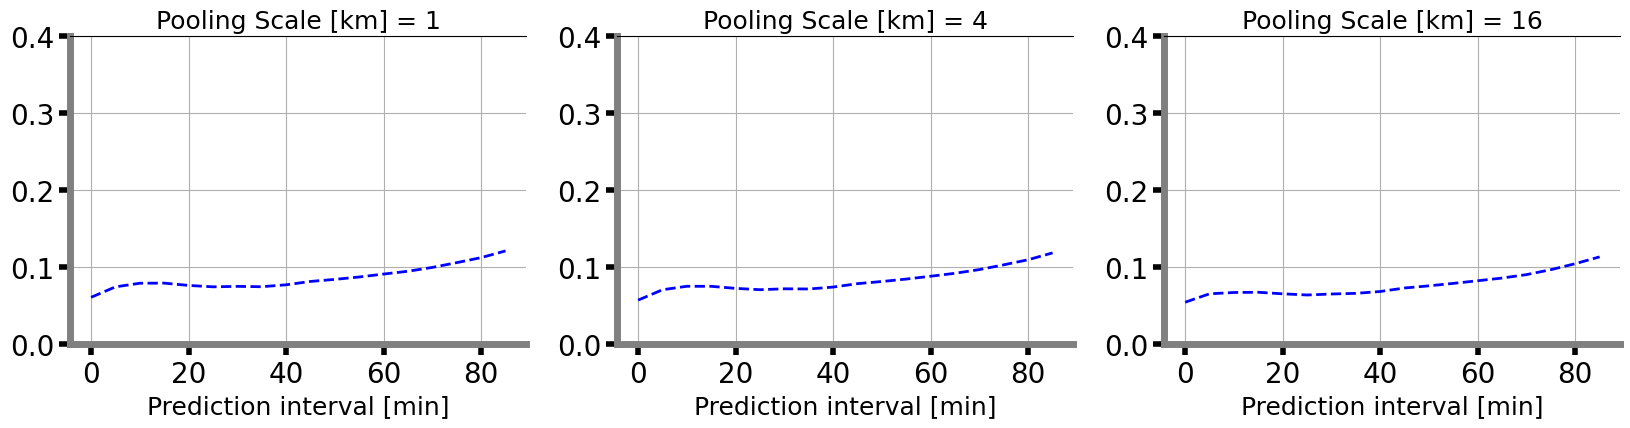

In [11]:
data = next(test_dataset.create_dict_iterator())

images = ops.cast(data["inputs"], ms.float32)

future_images = ops.cast(data["labels"], ms.float32)

pred = inference_module.forecast(g_model, images)

x, y = pred.squeeze(2), future_images.squeeze(2)
fig = plt.figure(figsize=(20, 4))
for index, scale in enumerate([1, 4, 16]):
    ax = fig.add_subplot(1, 3, index+1)
    crps_max_score = inference_module.cal_crps_max(x, y, scale=scale)
    plt_crps_max(crps_max_score, ax, index)


下图对第20个模型的真实值和预测值进行了可视化。

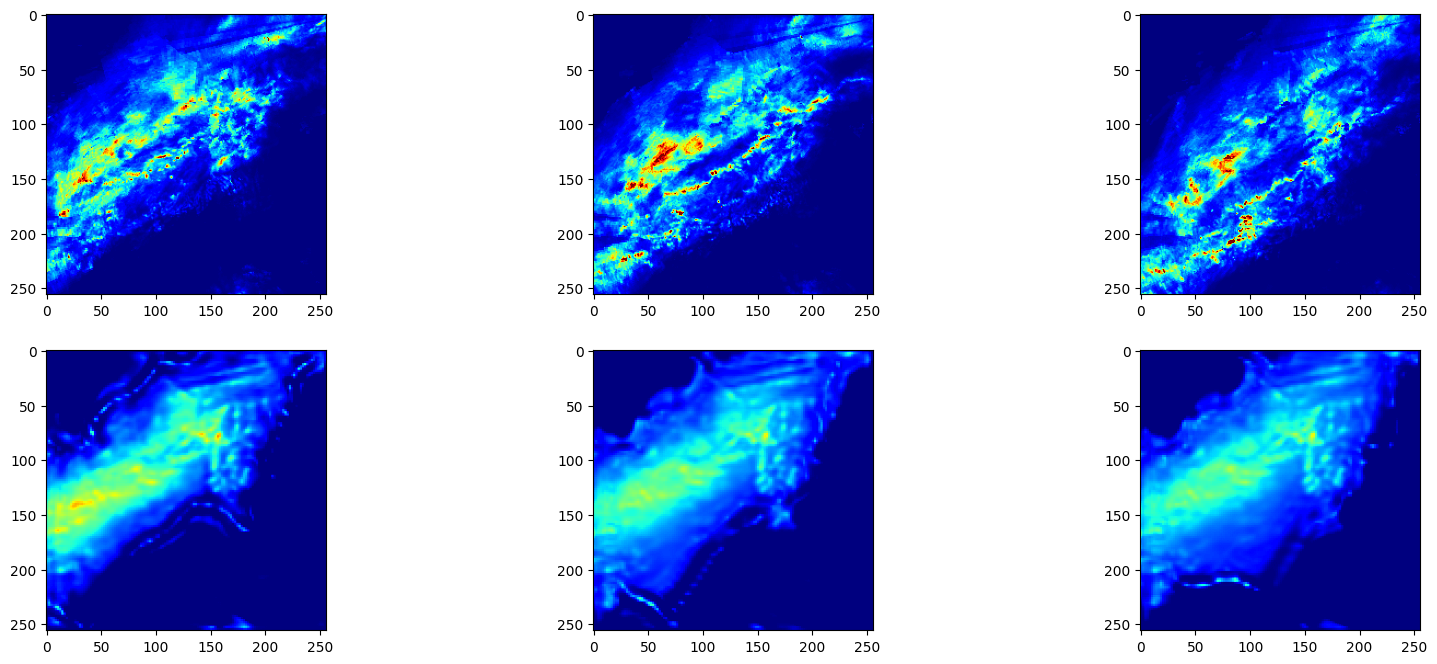

In [13]:
plt_radar_data(x, y)